In [1]:
import json
import pathlib

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

/workspace/venvs/ipa-gpt-interpret/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('iggy12345/rus-pol-edge-probing-phono-feats')

# Average span length

In [3]:
dataset = dataset.map(lambda x: {'span_length': (((x['windows']['end'][0] - x['windows']['start'][0] + 1) + (x['windows-phoneme']['end'][0] - x['windows-phoneme']['start'][0] + 1)) / 2) if len(x['windows']['start']) > 0 else 0})

In [4]:
average_length = 0
count = 0
for split in dataset:
    average_length += sum(dataset[split]['span_length'])
    count += len(dataset[split])
average_length /= count
print('average span length:', average_length)

average span length: 7.960183634578738


# Feature Distribution

In [5]:
supports = {}
for split in dataset:
    supports[split] = {}
    for row in dataset[split]:
        if len(row['features']) == 0:
            continue
        feats = row['features'][0]
        for feat in feats:
            if feat not in supports[split]:
                supports[split][feat] = 1
            else:
                supports[split][feat] += 1

In [13]:
lang_supports_counts = {
    'rus': {},
    'pol': {},
}
for row in dataset['train']:
    if len(row['features']) == 0:
        continue
    feats = row['features'][0]
    lang = row['language']
    for feat in feats:
        if feat not in lang_supports_counts[lang]:
            lang_supports_counts[lang][feat] = 1
        else:
            lang_supports_counts[lang][feat] += 1

In [7]:
with open('data/mappings.json', 'r') as fp:
    phoneme_mappings = json.load(fp)
inverse_mappings = {}
for k, v in phoneme_mappings['features'].items():
    inverse_mappings[v] = k

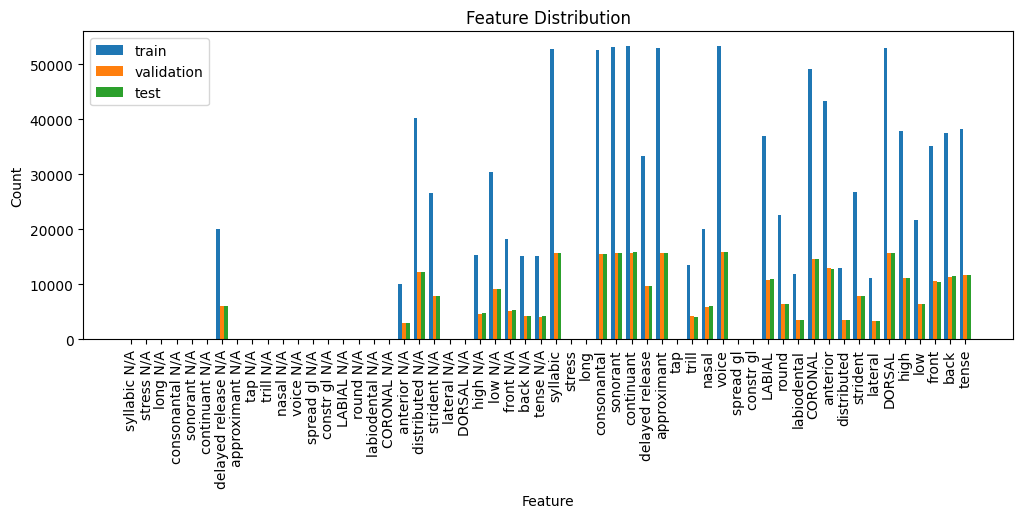

In [8]:
plt.figure(figsize=(12, 4))

width = 0.25

feature_ticks = np.arange(len(inverse_mappings) * 2)
feature_idxs = {}
labels = []
for feat in phoneme_mappings['features'].keys():
    feature_idxs[-phoneme_mappings['features'][feat]] = len(labels)
    labels.append(feat + ' N/A')
for feat in phoneme_mappings['features'].keys():
    feature_idxs[phoneme_mappings['features'][feat]] = len(labels)
    labels.append(feat)

for si, split in enumerate(supports.keys()):
    counts = np.zeros(feature_ticks.shape)
    for feat_idx in supports[split].keys():
        counts[feature_idxs[feat_idx]] = supports[split][feat_idx]
    plt.bar(feature_ticks + [-width, 0, width][si], counts, label=split, width=width)

plt.xlabel("Feature")
plt.xticks(feature_ticks, labels, rotation=90)
plt.ylabel("Count")
plt.title("Feature Distribution")
plt.legend()
plt.show()

# Feature Inventory

In [9]:
lang_supports = {}
for split in dataset:
    lang_supports[split] = {}
    for row in dataset[split]:
        if len(row['features']) == 0:
            continue
        lang = row['language']
        if lang not in lang_supports[split]:
            lang_supports[split][lang] = set()
        feats = row['features'][0]
        for feat in feats:
            if feat > 0:
                lang_supports[split][lang].add(feat)

In [10]:
for split in lang_supports:
    split_intersection = lang_supports[split]['rus'] & lang_supports[split]['pol']
    rus_invent = lang_supports[split]['rus'] - split_intersection
    pol_invent = lang_supports[split]['pol'] - split_intersection
    print(split)
    print('disjoint inventory:')
    print('russian:', rus_invent)
    print('polish:', pol_invent)
    print('combined:', split_intersection)

train
disjoint inventory:
russian: set()
polish: set()
combined: {1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
validation
disjoint inventory:
russian: {13}
polish: set()
combined: {1, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
test
disjoint inventory:
russian: {13}
polish: set()
combined: {1, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


In [11]:
split_intersection = lang_supports['train']['rus'] & lang_supports['train']['pol']
rus_invent = lang_supports['train']['rus'] - split_intersection
pol_invent = lang_supports['train']['pol'] - split_intersection

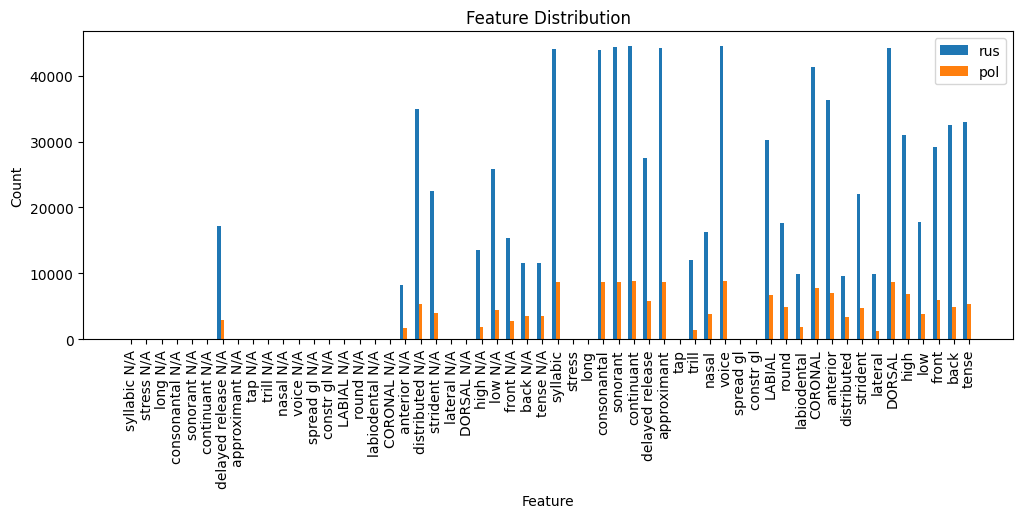

In [16]:
plt.figure(figsize=(12, 4))

width = 0.25

feature_ticks = np.arange(len(inverse_mappings) * 2)
feature_idxs = {}
labels = []
for feat in phoneme_mappings['features'].keys():
    feature_idxs[-phoneme_mappings['features'][feat]] = len(labels)
    labels.append(feat + ' N/A')
for feat in phoneme_mappings['features'].keys():
    feature_idxs[phoneme_mappings['features'][feat]] = len(labels)
    labels.append(feat)

counts = np.zeros(feature_ticks.shape)
for feat_idx in lang_supports_counts['rus'].keys():
    counts[feature_idxs[feat_idx]] = lang_supports_counts['rus'][feat_idx]
plt.bar(feature_ticks - width, counts, label='rus', width=width)
ounts = np.zeros(feature_ticks.shape)
for feat_idx in lang_supports_counts['pol'].keys():
    counts[feature_idxs[feat_idx]] = lang_supports_counts['pol'][feat_idx]
plt.bar(feature_ticks, counts, label='pol', width=width)

plt.xlabel("Feature")
plt.xticks(feature_ticks, labels, rotation=90)
plt.ylabel("Count")
plt.title("Feature Distribution")
plt.legend()
plt.show()

# Hidden State Contents

In [13]:
test_file = pathlib.Path('data/sample_hidden_state_12_04_2025.npy')
state = np.load(test_file, mmap_mode='r')
for layer in range(12):
    print(f'layer: {layer}', state[layer][-1][:5])

layer: 0 [ 0.4915 -0.1259 -0.0722 -0.1698  0.4636]
layer: 1 [-0.1755  -0.07117 -0.4297   0.4397   0.59   ]
layer: 2 [-0.4265  0.419  -0.5312  0.2484  0.2084]
layer: 3 [-0.651    0.9175  -0.571    0.4248   0.09796]
layer: 4 [-0.4575  1.506  -0.652   0.5625 -0.486 ]
layer: 5 [-1.027   1.781  -0.856   0.2208 -0.3997]
layer: 6 [-0.568  1.97  -0.833 -0.246 -0.557]
layer: 7 [-1.212  2.28  -0.837 -0.527 -1.073]
layer: 8 [-2.307   2.658  -1.851  -0.3113 -1.31  ]
layer: 9 [-2.926   2.322  -2.293  -0.9893 -0.9697]
layer: 10 [-1.956    2.969   -2.988   -0.03009 -1.446  ]
layer: 11 [-1.7705  2.816  -3.176   1.407  -1.261 ]


In [14]:
test_file = pathlib.Path('data/sample_hidden_state_2_12_04_2025.npy')
state = np.load(test_file, mmap_mode='r')
for layer in range(12):
    print(f'layer: {layer}', state[layer][-1][:5])

layer: 0 [ 0.5996  0.759   0.0218 -0.2903  0.5493]
layer: 1 [-0.1759  0.5625 -0.2651  0.0955  0.9556]
layer: 2 [-0.3098  0.745  -0.6367 -0.1047  0.1554]
layer: 3 [-0.3625  1.392  -0.783   0.1302 -0.164 ]
layer: 4 [ 0.07153  1.487   -0.676   -0.1295   0.03824]
layer: 5 [-0.198   1.788  -0.996  -0.978  -0.1962]
layer: 6 [-0.2893  2.307  -0.475  -2.004  -0.615 ]
layer: 7 [-0.2869   1.85    -0.02556 -2.29    -1.599  ]
layer: 8 [-0.5664   1.783    0.11505 -2.29    -1.927  ]
layer: 9 [-0.67    2.654   0.8384 -1.931  -2.336 ]
layer: 10 [-0.624  2.424  0.809 -1.649 -1.756]
layer: 11 [-0.1161  4.547   0.3403 -0.4348 -0.6235]
